In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
import time

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.FashionMNIST('Data_FashionMNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('DATA_FashionMNIST/', download=True, train=False, transform=transform)
testLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

cuda


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


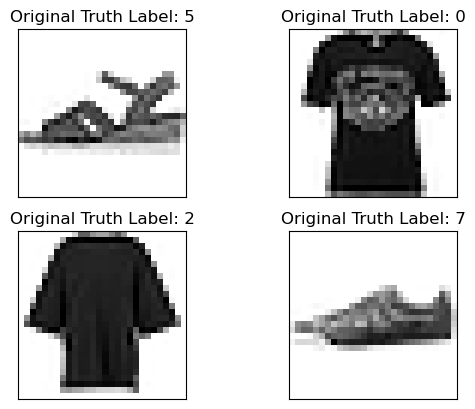

torch.Size([28, 28])


In [37]:
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)
print(type(images))
print(images.shape)
print(labels.shape)

fig = plt.figure()
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i][0], cmap='gray_r')
    plt.title("Original Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])
plt.show()
print(images[0][0].shape)

In [32]:
# Transfer learning
model = torchvision.models.resnet18(pretrained=True)
# Move the model to the selected device
model.to(device)


# Modify the first convolutional layer to accept single-channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False).to(device)


#num_features = model.fc.in_features  # Get the number of input features to the last fully connected layer
#model.fc = nn.Linear(num_features, 784).to(device) 

# Remove the final fully connected layers
# model = nn.Sequential(*list(model.children())[:-1])  # Remove the last fully connected layer

num_ftrs = model.fc.in_features  # Get the number of input features for the last FC layer
model.fc = nn.Linear(num_ftrs, 784).to(device)

print(model)
# Freeze the parameters so they are not updated during training
for param in model.parameters():
    param.requires_grad = False

# Define a function to extract features
def extract_features(loader, model):
    features = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.view(outputs.size(0), -1).cpu().numpy())
    return np.concatenate(features)

# Extract features from the train and test datasets
train_features = extract_features(trainLoader, model)
test_features = extract_features(testLoader, model)


# Now train GaussianMixture model on these extracted features
# Reshape the features to have only two dimensions
train_features_2d = train_features.reshape(-1, train_features.shape[-1])
test_features_2d = test_features.reshape(-1, test_features.shape[-1])

# Now train your GMM or any other model on these extracted features
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5)
gmm.fit(train_features_2d)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

GaussianMixture(n_components=5)

(28, 28)


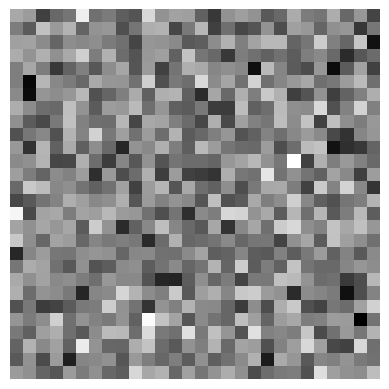

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Generate samples from the GMM
generated_samples = torch.tensor(gmm.sample(1)[0])
#generated_samples = torch.tensor((1,784))
generated_samples = generated_samples.view(28, 28).cpu().detach().numpy()
print(generated_samples.shape)

# Reshape the generated samples back into image dimensions
#generated_image = generated_samples.reshape(22, 22)

# Display the generated image
plt.imshow(generated_samples, cmap='gray')
plt.axis('off')
plt.show()


In [8]:
model

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Assign cluster labels to test features
test_labels = gmm.predict(test_features_2d)

# Step 2: Visualize cluster centers as images
cluster_centers = gmm.means_
cluster_centers_images = cluster_centers.reshape(-1, 28, 28)  # Reshape to image size

plt.figure(figsize=(10, 5))
for i in range(cluster_centers_images.shape[0]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cluster_centers_images[i], cmap='gray')
    plt.title(f'Cluster {i}')
    plt.axis('off')
plt.show()

# Step 3: Reconstruct sample images from each cluster
plt.figure(figsize=(10, 5))
for i in range(cluster_centers.shape[0]):
    cluster_samples = test_features_2d[test_labels == i][:5]  # Select 5 samples from each cluster
    for j, sample in enumerate(cluster_samples):
        reconstructed_image = np.dot(gmm.weights_, gmm.means_).reshape(28, 28)
        plt.subplot(5, 5, i * 5 + j + 1)
        plt.imshow(reconstructed_image, cmap='gray')
        plt.title(f'Cluster {i}')
        plt.axis('off')
plt.show()


ValueError: cannot reshape array of size 2560 into shape (28,28)

In [18]:
test_labels.shape

(10000,)

In [20]:
# Create a sample input tensor
sample_input = torch.randn(1, 1, 28, 28).to(device)  # Assuming input size is (batch_size, channels, height, width)

# Pass the input through the model
output = model(sample_input)

# Print the output shape
print("Output shape:", output.shape)

Output shape: torch.Size([1, 512, 1, 1])


In [21]:
output = output.view(output.size(0), output.size(1), 1, 1)

# Perform upsampling to increase the height and width to 28x28
output = F.interpolate(output, size=(28, 28), mode='nearest')

# Now, the shape of 'output' is [1, 512, 28, 28], but you want [1, 1, 28, 28]
# You can simply take the first channel (since there's only one channel) to get the desired shape
output = output[:, :1, :, :]

print("Transformed output shape:", output.shape)

Transformed output shape: torch.Size([1, 1, 28, 28])


In [46]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Step 1: Load the Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0))  # Convert grayscale to RGB
])

train_set = datasets.FashionMNIST('Data_FashionMNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)


# Step 2: Preprocess the data (no preprocessing needed for Fashion MNIST)

# Step 3: Use a pre-trained ResNet-18 model for feature extraction
resnet = torchvision.models.resnet18(pretrained=True)
resnet.fc = torch.nn.Identity()  # Remove the final fully connected layer

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)

# Function to extract features
def extract_features(data_loader, model):
    features = []
    labels = []
    for images, targets in data_loader:
        images = images.to(device)
        outputs = model(images)
        features.extend(outputs.cpu().detach().numpy())
        labels.extend(targets.numpy())
    return np.array(features), np.array(labels)

# Extract features
train_features, train_labels = extract_features(trainLoader, resnet)

# Step 4: Train a Gaussian Mixture Model (GMM) using the extracted features
gmm = GaussianMixture(n_components=10, covariance_type='full')
gmm.fit(train_features)

num_samples_per_class = 5
generated_images = []
for i in range(10):  # 10 classes in Fashion MNIST
    # Generate samples from the GMM
    samples = gmm.sample(num_samples_per_class)[0]
    # Decode the samples into images (assuming Gaussian distribution of pixel values)
    samples = np.clip(samples, 0, 1)
    images = samples.reshape(-1, 1, 28, 28)  # Reshape into images
    generated_images.extend(images)

# Step 6: Plot some of the generated images
fig, axes = plt.subplots(10, num_samples_per_class, figsize=(num_samples_per_class, 10))
for i in range(10):
    for j in range(num_samples_per_class):
        axes[i, j].imshow(generated_images[i * num_samples_per_class + j].transpose(1, 2, 0))
        axes[i, j].axis('off')
plt.show()


/home/daniel/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/daniel/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ValueError: cannot reshape array of size 2560 into shape (1,28,28)